## GAN 구현
GAN 예제 역시 MNIST 데이터셋을 사용하여 파이토치로 구현하는 방법을 알아보겠습니다.

먼저 필요한 라이브러리를 호출합니다.

In [1]:
import imageio # 이미지 데이터를 읽고 쓸 수 있는 쉬운 인터페이스를 제공하는 라이브러리
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\aqs45\OneDrive\바탕 화면\repo\Python_AI\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* matplotlib 라이브러리는 시각화에 사용합니다. 맷플롯립은 폰트, 색상 등을 변경하여 사용할 수 있는데 예제에서는 스타일시트(stylesheet)를 바꾸어서 사용했습니다. 스타일시트로 사용할 수 있는 것들은 다음 코드와 같이 확인할 수 있습니다.

```py
import matplotlib.pyplot as plt
plt.style.available
```
 
`ggplot` 스타일시트는 다음 그림과 같이 격자무늬에 백그라운드를 삽입하고자 할 때 사용합니다.  

![](../Static/713.jpg)  

학습을 위해 사용 가능한 스타일시트를 하나씩 적용해 보는 것도 도움이 됩니다.

필요한 변수에 대한 값을 지정합니다.


In [2]:
batch_size = 512
epochs = 200
sample_size = 64
nz = 128
k = 1

* `sample_size` 노이즈 벡터를 사용하여 가짜 이미지를 생성합니다. sample_size는 생성자에 제공할 고정크기의 노이즈 벡터에 대한 크기입니다.

* `nz` 잠재 벡터의 크기를 의미합니다. 이때 잠재 벡터의 크기는 생성자의 입력 크기와 동일해야합니다.

* `k` 판별자에 적용할 스탭 수를 의미합니다. 스텝 수를 1로 지정한 이유는 훈련 비용을 최소화하기 위함입니다.

예제에서 진행할 MNIST를 내려받아 정규화를 적용합니다. 이후에는 데이터로더에 데이터를 전달하여 모델의 학습에 사용할 수 있도록 합니다.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), # 이미지를 텐서로 변환
    transforms.Normalize((0.5), (0.5)) # 이미지 평균이 0.5, 표준편차가 0.5가 되도록 정규화
])

train_dataset = datasets.MNIST(
    root='./MNIST_DATA/',
    train=True,
    transform=transform,
    download=True,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

데이터셋이 준비되었기 때문에 네트워크를 생성할 텐데, 먼저 생성자 네트워크를 만들어보겠습니다.

간단한 예제를 위해 `네 개의 선형 계층`과 `세 개의 리키렐루(Leaky ReLU)` 활성화 함수를 사용합니다.

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28) # 생성자 네트워크의 반환값은 '배치 크기 x 1 x 28 x 28이 됩니다

생성자 네트워크가 완료되었고, 이제 판별자 네트워크를 생성해 보겠습니다. 판별자는 이진분류자라는 것을 고려하여 신경망을 구축해야 합니다.

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784 # 판별자의 입력 크기
        self.main = nn.Sequential(
            # 판별자 역시 선형 계층과 리키렐루 활성화 함수로 구성
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x) # 이미지가 진짜인지 가짜인지 분류하는 값을 반환
    

앞에서 생성한 생성자와 판별자 네트워크를 초기화합니다. 이때 생성자는 `잠재 벡터 nz`라는 변수를 파라미터로 전달해야 합니다.

In [6]:
generator = Generator(nz).to(device=device)
discriminator = Discriminator().to(device=device)

print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


이제 모델의 네트워크에서 사용할 `옵티마이저`와 `손실 함수`를 정의합니다. 중요한 것은 생성자와 판별자에서 사용할 옵티마이저를 따로 정의헤애 한다는 것입니다.

In [7]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] # 매 에포크마다 발생하는 생성자 오차를 저장하기 위한 리스트형 변수
losses_d = [] # 매 에포크마다 발생하는 판별자 오차를 저장하기 위한 리스트형 변수

images = [] # 생성자에 의해 생성되는 이미지를 저장하기 위한 리스트형 변수

생성자에 의해 만들어지는 새로운 이미지(텐서)를 저장하기 위한 함수를 저장합니다. 이 함수는 모델 학습에 반드시 필요한 것은 아니지만 이미지가 생성되는 과정을 이해할 수 있도록 시각화하여 보여 줍니다.

In [8]:
# 생성된 이미지 저장 함수 정의
def save_generator_image(image, path):
    save_image(image, path)

판별자를 학습시키기 위한 함수를 정의합니다. 판별자의 학습은 진짜 데이터의 레이블과 가짜 데이터의 레이블을 모두 이용하여 학습합니다.

In [9]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0) # 배치 크기 정보 얻기
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)

    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label) # 진짜 데이터를 판별자에 제공하여 학습한 결과와 진짜 데이터의 레이블을 이용하여 오차를 계산

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label) # 가짜 데이터를 판별자에 제공하여 학습한 결과와 가짜 데이터의 레이블을 이용하여 오차를 계산

    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake # 진짜 데이터와 가짜 데이터의 오차가 합쳐진 최종 오차를 반환

* `torch.ones(b_size, 1).to(device)` GAN에서는 모델 훈련을 위해 진짜 이미지와 생성자에서 생성한 가짜 이미지가 필요합니다. 그뿐만 아니라 레이블 정보도 필요한데, 레이블 정보는 텐서 형태를 가져야 하며 배치 크기와도 동일해야 합니다. 먼저 진짜 데이터에 대한 레이블을 생성합니다.
    * 1 값을 가진 (b_size x 1) 크기의 텐서를 생성

* `torch.zeros(b_size, 1).to(device)` 가짜 데이터에 대한 레이블을 생성합니다.
    * 0 값을 가진 (b_size x 1) 크기의 텐서를 생성

이제 생성자 학습을 위한 함수를 정의할 텐데, 상대적으로 판별자의 네트워크보다는 간단합니다.

In [10]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)

    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

생성자 네트워크에서는 가짜 데이터만 사용하고 있는데, 생성자 입장에서는 가짜 데이터가 실제로 진짜라는 것에 주의할 필요가 있습니다.

이제 `for` 구문을 이용하여 200 에포크만큼 모델을 학습시킵니다.

In [17]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0 # 생성자 오차를 추적하기 위한 변수
    loss_d = 0.0 # 판별자 오차를 추적하기 위한 변수

    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset) / train_loader.batch_size)):
        image, _ = data # 학습을 위한 이미지 데이터를 가져옵니다.
        image = image.to(device) # 데이터셋이 cpu/gpu 장치를 사용하도록 지정
        b_size = len(image)
        for step in range(k): # 스텝 수에 따라 판별자를 실행, 이때 k 수를 증가시킬 수 있지만 학습 시간이 길어질 수 있으므로 주의하세요
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake) # 생성자 학습
    
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()  # 생성자를 이용하여 새로운 이미지를 생성하고 CPU 장치를 이용하여 디스크에 저장
    generated_img = make_grid(generated_img) # 이미지를 그리드 형태로 표현
    save_generator_image(generated_img, f'./GANmodelIMG/gen_img{epoch}.png') # 생성된 이미지(텐서)를 디스크에 저장

    images.append(generated_img)
    epoch_loss_g = loss_g / idx # 에포크에 대한 총 생성자 오차 계산
    epoch_loss_d = loss_d / idx # 에포크에 대한 총 판별자 오차 계산
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f'Epoch {epoch} of {epochs}')
    print(f'Generator loss: {epoch_loss_g:.8f}, Discriminator los: {epoch_loss_d:.8f}')

118it [00:03, 32.80it/s]                         


Epoch 0 of 200
Generator loss: 2.07646418, Discriminator los: 1.01499629


118it [00:03, 35.28it/s]                         


Epoch 1 of 200
Generator loss: 2.44196033, Discriminator los: 0.86658126


118it [00:03, 32.47it/s]                         


Epoch 2 of 200
Generator loss: 2.77347231, Discriminator los: 1.09761310


118it [00:03, 31.99it/s]                         


Epoch 3 of 200
Generator loss: 3.05878758, Discriminator los: 0.98368233


118it [00:03, 31.21it/s]                         


Epoch 4 of 200
Generator loss: 1.13886714, Discriminator los: 1.13518095


118it [00:03, 30.95it/s]                         


Epoch 5 of 200
Generator loss: 2.16137838, Discriminator los: 0.85939580


118it [00:03, 30.23it/s]                         


Epoch 6 of 200
Generator loss: 1.04129338, Discriminator los: 1.37269843


118it [00:04, 28.60it/s]                         


Epoch 7 of 200
Generator loss: 1.67150807, Discriminator los: 0.95255786


118it [00:04, 27.83it/s]                         


Epoch 8 of 200
Generator loss: 2.48632741, Discriminator los: 0.90074706


118it [00:04, 27.23it/s]                         


Epoch 9 of 200
Generator loss: 1.94579089, Discriminator los: 0.92265797


118it [00:04, 28.26it/s]                         


Epoch 10 of 200
Generator loss: 2.17510700, Discriminator los: 0.86898369


118it [00:04, 27.79it/s]                         


Epoch 11 of 200
Generator loss: 2.70867133, Discriminator los: 0.84800005


118it [00:04, 27.58it/s]                         


Epoch 12 of 200
Generator loss: 2.30542517, Discriminator los: 0.72525769


118it [00:04, 27.86it/s]                         


Epoch 13 of 200
Generator loss: 2.90165091, Discriminator los: 0.63660413


118it [00:04, 27.29it/s]                         


Epoch 14 of 200
Generator loss: 2.40866351, Discriminator los: 0.64549267


118it [00:04, 26.95it/s]                         


Epoch 15 of 200
Generator loss: 2.47662020, Discriminator los: 0.61903721


118it [00:04, 27.04it/s]                         


Epoch 16 of 200
Generator loss: 2.88859916, Discriminator los: 0.55843687


118it [00:04, 26.17it/s]                         


Epoch 17 of 200
Generator loss: 3.05943727, Discriminator los: 0.52021432


118it [00:04, 25.38it/s]                         


Epoch 18 of 200
Generator loss: 2.68095684, Discriminator los: 0.52000916


118it [00:04, 25.47it/s]                         


Epoch 19 of 200
Generator loss: 2.78443408, Discriminator los: 0.69290799


118it [00:04, 25.50it/s]                         


Epoch 20 of 200
Generator loss: 2.36916637, Discriminator los: 0.54160011


118it [00:04, 25.16it/s]                         


Epoch 21 of 200
Generator loss: 2.80926466, Discriminator los: 0.43498889


118it [00:04, 24.91it/s]                         


Epoch 22 of 200
Generator loss: 3.36052728, Discriminator los: 0.37635189


118it [00:05, 23.04it/s]                         


Epoch 23 of 200
Generator loss: 3.36118722, Discriminator los: 0.44064856


118it [00:04, 23.78it/s]                         


Epoch 24 of 200
Generator loss: 3.63714647, Discriminator los: 0.42744300


118it [00:04, 23.60it/s]                         


Epoch 25 of 200
Generator loss: 3.99451494, Discriminator los: 0.36694720


118it [00:05, 22.75it/s]                         


Epoch 26 of 200
Generator loss: 3.56190920, Discriminator los: 0.38199010


118it [00:05, 22.53it/s]                         


Epoch 27 of 200
Generator loss: 3.42805600, Discriminator los: 0.49109912


118it [00:05, 22.57it/s]                         


Epoch 28 of 200
Generator loss: 3.12211704, Discriminator los: 0.49570045


118it [00:05, 21.80it/s]                         


Epoch 29 of 200
Generator loss: 3.03525615, Discriminator los: 0.59676117


118it [00:05, 21.13it/s]                         


Epoch 30 of 200
Generator loss: 2.96749473, Discriminator los: 0.48858827


118it [00:05, 20.66it/s]                         


Epoch 31 of 200
Generator loss: 3.16103745, Discriminator los: 0.43660039


118it [00:05, 19.99it/s]                         


Epoch 32 of 200
Generator loss: 3.27875996, Discriminator los: 0.47875902


118it [00:06, 18.99it/s]                         


Epoch 33 of 200
Generator loss: 2.92187929, Discriminator los: 0.54789549


118it [00:06, 18.51it/s]                         


Epoch 34 of 200
Generator loss: 3.00687718, Discriminator los: 0.54450732


118it [00:06, 17.39it/s]                         


Epoch 35 of 200
Generator loss: 3.06597900, Discriminator los: 0.44161630


118it [00:07, 16.32it/s]                         


Epoch 36 of 200
Generator loss: 3.42594981, Discriminator los: 0.38709110


118it [00:08, 14.47it/s]                         


Epoch 37 of 200
Generator loss: 3.32113028, Discriminator los: 0.40756026


118it [00:08, 13.70it/s]                         


Epoch 38 of 200
Generator loss: 3.26466799, Discriminator los: 0.52519584


118it [00:09, 12.04it/s]                         


Epoch 39 of 200
Generator loss: 3.34531236, Discriminator los: 0.46123323


118it [00:10, 11.56it/s]                         


Epoch 40 of 200
Generator loss: 3.44041920, Discriminator los: 0.37179953


118it [00:10, 11.54it/s]                         


Epoch 41 of 200
Generator loss: 3.70824885, Discriminator los: 0.35214594


118it [00:09, 11.81it/s]                         


Epoch 42 of 200
Generator loss: 3.56091762, Discriminator los: 0.38864902


118it [00:09, 11.99it/s]                         


Epoch 43 of 200
Generator loss: 3.25553584, Discriminator los: 0.49653316


118it [00:10, 11.76it/s]                         


Epoch 44 of 200
Generator loss: 3.01905465, Discriminator los: 0.51945353


118it [00:09, 11.83it/s]                         


Epoch 45 of 200
Generator loss: 2.70418048, Discriminator los: 0.52428395


118it [00:09, 11.84it/s]                         


Epoch 46 of 200
Generator loss: 2.97694850, Discriminator los: 0.45994234


118it [00:09, 11.93it/s]                         


Epoch 47 of 200
Generator loss: 3.09443378, Discriminator los: 0.49562076


118it [00:09, 11.84it/s]                         


Epoch 48 of 200
Generator loss: 3.06715918, Discriminator los: 0.54695165


118it [00:10, 11.72it/s]                         


Epoch 49 of 200
Generator loss: 2.91555929, Discriminator los: 0.52468640


118it [00:09, 12.17it/s]                         


Epoch 50 of 200
Generator loss: 2.86519337, Discriminator los: 0.52008325


118it [00:08, 13.90it/s]                         


Epoch 51 of 200
Generator loss: 3.04291892, Discriminator los: 0.45766491


118it [00:08, 14.68it/s]                         


Epoch 52 of 200
Generator loss: 2.84217787, Discriminator los: 0.55082107


118it [00:07, 15.73it/s]                         


Epoch 53 of 200
Generator loss: 2.81665993, Discriminator los: 0.55875790


118it [00:08, 14.19it/s]                         


Epoch 54 of 200
Generator loss: 2.69703507, Discriminator los: 0.59766608


118it [00:08, 13.31it/s]                         


Epoch 55 of 200
Generator loss: 2.51051641, Discriminator los: 0.62207222


118it [00:09, 12.73it/s]                         


Epoch 56 of 200
Generator loss: 2.45845771, Discriminator los: 0.60403901


118it [00:09, 12.19it/s]                         


Epoch 57 of 200
Generator loss: 2.58112764, Discriminator los: 0.56157666


118it [00:07, 15.03it/s]                         


Epoch 58 of 200
Generator loss: 2.48223829, Discriminator los: 0.56950831


118it [00:07, 16.14it/s]                         


Epoch 59 of 200
Generator loss: 2.78688765, Discriminator los: 0.54439175


118it [00:07, 16.57it/s]                         


Epoch 60 of 200
Generator loss: 2.64069629, Discriminator los: 0.58273107


118it [00:07, 16.20it/s]                         


Epoch 61 of 200
Generator loss: 2.48293734, Discriminator los: 0.59688336


118it [00:07, 15.81it/s]                         


Epoch 62 of 200
Generator loss: 2.47397923, Discriminator los: 0.60779637


118it [00:07, 15.60it/s]                         


Epoch 63 of 200
Generator loss: 2.44817686, Discriminator los: 0.60717958


118it [00:08, 14.19it/s]                         


Epoch 64 of 200
Generator loss: 2.44532323, Discriminator los: 0.60439664


118it [00:09, 12.38it/s]                         


Epoch 65 of 200
Generator loss: 2.30725002, Discriminator los: 0.63240761


118it [00:09, 12.31it/s]                         


Epoch 66 of 200
Generator loss: 2.40565181, Discriminator los: 0.66015846


118it [00:09, 12.87it/s]                         


Epoch 67 of 200
Generator loss: 2.42192936, Discriminator los: 0.66051781


118it [00:07, 15.24it/s]                         


Epoch 68 of 200
Generator loss: 2.41113949, Discriminator los: 0.63313180


118it [00:07, 15.97it/s]                         


Epoch 69 of 200
Generator loss: 2.40070868, Discriminator los: 0.65521938


118it [00:07, 16.63it/s]                         


Epoch 70 of 200
Generator loss: 2.27891469, Discriminator los: 0.67041469


118it [00:07, 16.17it/s]                         


Epoch 71 of 200
Generator loss: 2.30573893, Discriminator los: 0.64667958


118it [00:07, 15.88it/s]                         


Epoch 72 of 200
Generator loss: 2.38674045, Discriminator los: 0.64539284


118it [00:08, 13.72it/s]                         


Epoch 73 of 200
Generator loss: 2.42271972, Discriminator los: 0.65687537


118it [00:10, 11.62it/s]                         


Epoch 74 of 200
Generator loss: 2.38447666, Discriminator los: 0.65505272


118it [00:11, 10.42it/s]                         


Epoch 75 of 200
Generator loss: 2.32806635, Discriminator los: 0.66896123


118it [00:10, 10.84it/s]                         


Epoch 76 of 200
Generator loss: 2.44690037, Discriminator los: 0.68250453


118it [00:08, 13.66it/s]                         


Epoch 77 of 200
Generator loss: 2.28900671, Discriminator los: 0.70094806


118it [00:07, 16.78it/s]                         


Epoch 78 of 200
Generator loss: 2.25735116, Discriminator los: 0.68746859


118it [00:06, 17.26it/s]                         


Epoch 79 of 200
Generator loss: 2.26377916, Discriminator los: 0.67431492


118it [00:06, 17.42it/s]                         


Epoch 80 of 200
Generator loss: 2.24050856, Discriminator los: 0.69783664


118it [00:06, 17.02it/s]                         


Epoch 81 of 200
Generator loss: 2.14198256, Discriminator los: 0.72373569


118it [00:06, 16.87it/s]                         


Epoch 82 of 200
Generator loss: 2.12437534, Discriminator los: 0.73022228


118it [00:07, 16.51it/s]                         


Epoch 83 of 200
Generator loss: 2.15528870, Discriminator los: 0.71884203


118it [00:07, 16.52it/s]                         


Epoch 84 of 200
Generator loss: 2.16100740, Discriminator los: 0.71113312


118it [00:07, 15.69it/s]                         


Epoch 85 of 200
Generator loss: 2.14117694, Discriminator los: 0.71816403


118it [00:07, 14.78it/s]                         


Epoch 86 of 200
Generator loss: 2.16607642, Discriminator los: 0.68700653


118it [00:08, 13.20it/s]                         


Epoch 87 of 200
Generator loss: 2.05600786, Discriminator los: 0.71929669


118it [00:10, 11.65it/s]                         


Epoch 88 of 200
Generator loss: 2.12921095, Discriminator los: 0.73381621


118it [00:10, 11.66it/s]                         


Epoch 89 of 200
Generator loss: 2.18412542, Discriminator los: 0.73778886


118it [00:09, 12.24it/s]                         


Epoch 90 of 200
Generator loss: 2.09583879, Discriminator los: 0.73543090


118it [00:08, 14.66it/s]                         


Epoch 91 of 200
Generator loss: 2.12551641, Discriminator los: 0.72867525


118it [00:07, 15.80it/s]                         


Epoch 92 of 200
Generator loss: 2.06601286, Discriminator los: 0.75032324


118it [00:06, 16.91it/s]                         


Epoch 93 of 200
Generator loss: 2.00183439, Discriminator los: 0.75577432


118it [00:06, 17.25it/s]                         


Epoch 94 of 200
Generator loss: 2.01131225, Discriminator los: 0.80338734


118it [00:06, 17.12it/s]                         


Epoch 95 of 200
Generator loss: 1.90388346, Discriminator los: 0.81814307


118it [00:07, 16.31it/s]                         


Epoch 96 of 200
Generator loss: 1.92198038, Discriminator los: 0.82386392


118it [00:07, 15.98it/s]                         


Epoch 97 of 200
Generator loss: 1.74631870, Discriminator los: 0.86007047


118it [00:07, 14.91it/s]                         


Epoch 98 of 200
Generator loss: 1.87321651, Discriminator los: 0.81268322


118it [00:08, 14.51it/s]                         


Epoch 99 of 200
Generator loss: 1.88945627, Discriminator los: 0.81205833


118it [00:09, 12.41it/s]                         


Epoch 100 of 200
Generator loss: 1.96296608, Discriminator los: 0.80010664


118it [00:10, 11.53it/s]                         


Epoch 101 of 200
Generator loss: 1.82847810, Discriminator los: 0.84046179


118it [00:09, 11.91it/s]                         


Epoch 102 of 200
Generator loss: 1.87782872, Discriminator los: 0.80462283


118it [00:07, 15.10it/s]                         


Epoch 103 of 200
Generator loss: 1.95784080, Discriminator los: 0.81358659


118it [00:07, 16.20it/s]                         


Epoch 104 of 200
Generator loss: 1.69808006, Discriminator los: 0.87625241


118it [00:07, 16.65it/s]                         


Epoch 105 of 200
Generator loss: 1.82974398, Discriminator los: 0.83350760


118it [00:06, 17.22it/s]                         


Epoch 106 of 200
Generator loss: 1.82570040, Discriminator los: 0.85480285


118it [00:06, 17.06it/s]                         


Epoch 107 of 200
Generator loss: 1.86792409, Discriminator los: 0.82958829


118it [00:07, 16.68it/s]                         


Epoch 108 of 200
Generator loss: 1.81156325, Discriminator los: 0.83457583


118it [00:07, 16.57it/s]                         


Epoch 109 of 200
Generator loss: 1.79747653, Discriminator los: 0.84464091


118it [00:07, 16.53it/s]                         


Epoch 110 of 200
Generator loss: 1.86135256, Discriminator los: 0.87631220


118it [00:07, 15.71it/s]                         


Epoch 111 of 200
Generator loss: 1.74329257, Discriminator los: 0.89049125


118it [00:08, 14.36it/s]                         


Epoch 112 of 200
Generator loss: 1.74172866, Discriminator los: 0.86658984


118it [00:09, 12.76it/s]                         


Epoch 113 of 200
Generator loss: 1.78242695, Discriminator los: 0.84983712


118it [00:10, 11.62it/s]                         


Epoch 114 of 200
Generator loss: 1.76377177, Discriminator los: 0.87804848


118it [00:10, 11.23it/s]                         


Epoch 115 of 200
Generator loss: 1.77876329, Discriminator los: 0.86145055


118it [00:08, 13.60it/s]                         


Epoch 116 of 200
Generator loss: 1.74983990, Discriminator los: 0.88507503


118it [00:07, 16.29it/s]                         


Epoch 117 of 200
Generator loss: 1.87125456, Discriminator los: 0.83575624


118it [00:07, 16.82it/s]                         


Epoch 118 of 200
Generator loss: 1.82201076, Discriminator los: 0.83183461


118it [00:06, 17.25it/s]                         


Epoch 119 of 200
Generator loss: 1.77459562, Discriminator los: 0.86727643


118it [00:07, 16.76it/s]                         


Epoch 120 of 200
Generator loss: 1.74138772, Discriminator los: 0.88334072


118it [00:07, 16.44it/s]                         


Epoch 121 of 200
Generator loss: 1.66962111, Discriminator los: 0.90912437


118it [00:07, 16.16it/s]                         


Epoch 122 of 200
Generator loss: 1.71513283, Discriminator los: 0.90063852


118it [00:07, 15.36it/s]                         


Epoch 123 of 200
Generator loss: 1.74572754, Discriminator los: 0.87541330


118it [00:08, 13.91it/s]                         


Epoch 124 of 200
Generator loss: 1.70938694, Discriminator los: 0.91668528


118it [00:09, 12.22it/s]                         


Epoch 125 of 200
Generator loss: 1.71585953, Discriminator los: 0.89299011


118it [00:10, 11.30it/s]                         


Epoch 126 of 200
Generator loss: 1.73120546, Discriminator los: 0.86929280


118it [00:10, 11.31it/s]                         


Epoch 127 of 200
Generator loss: 1.69383109, Discriminator los: 0.88959497


118it [00:08, 14.55it/s]                         


Epoch 128 of 200
Generator loss: 1.67349184, Discriminator los: 0.90434748


118it [00:07, 16.36it/s]                         


Epoch 129 of 200
Generator loss: 1.72507310, Discriminator los: 0.87300509


118it [00:07, 16.72it/s]                         


Epoch 130 of 200
Generator loss: 1.66084063, Discriminator los: 0.90589702


118it [00:06, 17.03it/s]                         


Epoch 131 of 200
Generator loss: 1.68344998, Discriminator los: 0.91367221


118it [00:07, 16.85it/s]                         


Epoch 132 of 200
Generator loss: 1.60718060, Discriminator los: 0.92973351


118it [00:07, 16.70it/s]                         


Epoch 133 of 200
Generator loss: 1.63211691, Discriminator los: 0.94066775


118it [00:07, 16.28it/s]                         


Epoch 134 of 200
Generator loss: 1.62903428, Discriminator los: 0.91847211


118it [00:07, 15.68it/s]                         


Epoch 135 of 200
Generator loss: 1.61686432, Discriminator los: 0.92962241


118it [00:08, 14.19it/s]                         


Epoch 136 of 200
Generator loss: 1.55307186, Discriminator los: 0.94835705


118it [00:09, 12.53it/s]                         


Epoch 137 of 200
Generator loss: 1.58269632, Discriminator los: 0.95079517


118it [00:10, 11.80it/s]                         


Epoch 138 of 200
Generator loss: 1.53923666, Discriminator los: 0.96720707


118it [00:09, 12.43it/s]                         


Epoch 139 of 200
Generator loss: 1.60335362, Discriminator los: 0.92697805


118it [00:07, 15.27it/s]                         


Epoch 140 of 200
Generator loss: 1.51888740, Discriminator los: 0.97706938


118it [00:07, 16.35it/s]                         


Epoch 141 of 200
Generator loss: 1.51704252, Discriminator los: 0.96296203


118it [00:07, 16.62it/s]                         


Epoch 142 of 200
Generator loss: 1.51495421, Discriminator los: 0.95928824


118it [00:06, 17.04it/s]                         


Epoch 143 of 200
Generator loss: 1.50902021, Discriminator los: 0.98003036


118it [00:07, 16.10it/s]                         


Epoch 144 of 200
Generator loss: 1.56802988, Discriminator los: 0.95459127


118it [00:07, 16.00it/s]                         


Epoch 145 of 200
Generator loss: 1.50769353, Discriminator los: 0.96393889


118it [00:07, 15.31it/s]                         


Epoch 146 of 200
Generator loss: 1.45768058, Discriminator los: 0.99827754


118it [00:08, 13.77it/s]                         


Epoch 147 of 200
Generator loss: 1.47790229, Discriminator los: 0.98449743


118it [00:09, 12.09it/s]                         


Epoch 148 of 200
Generator loss: 1.49128544, Discriminator los: 0.97355378


118it [00:10, 11.73it/s]                         


Epoch 149 of 200
Generator loss: 1.51811433, Discriminator los: 0.96790528


118it [00:08, 13.98it/s]                         


Epoch 150 of 200
Generator loss: 1.51439965, Discriminator los: 0.98655647


118it [00:07, 15.46it/s]                         


Epoch 151 of 200
Generator loss: 1.51795876, Discriminator los: 0.96751195


118it [00:07, 16.09it/s]                         


Epoch 152 of 200
Generator loss: 1.58875167, Discriminator los: 0.93827677


118it [00:06, 17.66it/s]                         


Epoch 153 of 200
Generator loss: 1.49496949, Discriminator los: 0.98799717


118it [00:06, 17.87it/s]                         


Epoch 154 of 200
Generator loss: 1.47575688, Discriminator los: 0.99197674


118it [00:06, 17.67it/s]                         


Epoch 155 of 200
Generator loss: 1.46060181, Discriminator los: 0.97626084


118it [00:08, 13.46it/s]                         


Epoch 156 of 200
Generator loss: 1.48637915, Discriminator los: 0.98635077


118it [00:07, 16.74it/s]                         


Epoch 157 of 200
Generator loss: 1.45365000, Discriminator los: 0.99690616


118it [00:07, 16.72it/s]                         


Epoch 158 of 200
Generator loss: 1.41951883, Discriminator los: 1.02037024


118it [00:07, 16.35it/s]                         


Epoch 159 of 200
Generator loss: 1.42782414, Discriminator los: 1.01586020


118it [00:07, 15.15it/s]                         


Epoch 160 of 200
Generator loss: 1.40210748, Discriminator los: 1.01565576


118it [00:08, 13.84it/s]                         


Epoch 161 of 200
Generator loss: 1.37956774, Discriminator los: 1.04192472


118it [00:09, 12.35it/s]                         


Epoch 162 of 200
Generator loss: 1.34724677, Discriminator los: 1.03964126


118it [00:09, 12.02it/s]                         


Epoch 163 of 200
Generator loss: 1.33516252, Discriminator los: 1.04627323


118it [00:09, 12.84it/s]                         


Epoch 164 of 200
Generator loss: 1.35914040, Discriminator los: 1.02913797


118it [00:07, 15.62it/s]                         


Epoch 165 of 200
Generator loss: 1.35997450, Discriminator los: 1.03565121


118it [00:06, 17.23it/s]                         


Epoch 166 of 200
Generator loss: 1.38121390, Discriminator los: 1.03623831


118it [00:06, 17.49it/s]                         


Epoch 167 of 200
Generator loss: 1.34565389, Discriminator los: 1.05426121


118it [00:06, 17.77it/s]                         


Epoch 168 of 200
Generator loss: 1.31994569, Discriminator los: 1.04256475


118it [00:06, 17.74it/s]                         


Epoch 169 of 200
Generator loss: 1.36938488, Discriminator los: 1.04056883


118it [00:06, 17.53it/s]                         


Epoch 170 of 200
Generator loss: 1.34976089, Discriminator los: 1.05531394


118it [00:06, 17.12it/s]                         


Epoch 171 of 200
Generator loss: 1.34461665, Discriminator los: 1.04490113


118it [00:06, 17.18it/s]                         


Epoch 172 of 200
Generator loss: 1.34404051, Discriminator los: 1.05874360


118it [00:07, 16.22it/s]                         


Epoch 173 of 200
Generator loss: 1.40605783, Discriminator los: 1.01487243


118it [00:07, 15.25it/s]                         


Epoch 174 of 200
Generator loss: 1.31102931, Discriminator los: 1.05873239


118it [00:08, 13.96it/s]                         


Epoch 175 of 200
Generator loss: 1.32397783, Discriminator los: 1.06452489


118it [00:09, 12.31it/s]                         


Epoch 176 of 200
Generator loss: 1.34444273, Discriminator los: 1.04953861


118it [00:09, 12.49it/s]                         


Epoch 177 of 200
Generator loss: 1.31890678, Discriminator los: 1.06064916


118it [00:07, 15.44it/s]                         


Epoch 178 of 200
Generator loss: 1.36963344, Discriminator los: 1.03469253


118it [00:06, 16.88it/s]                         


Epoch 179 of 200
Generator loss: 1.30156970, Discriminator los: 1.08021438


118it [00:06, 17.50it/s]                         


Epoch 180 of 200
Generator loss: 1.33505964, Discriminator los: 1.06529891


118it [00:06, 17.99it/s]                         


Epoch 181 of 200
Generator loss: 1.33828056, Discriminator los: 1.05769718


118it [00:06, 18.03it/s]                         


Epoch 182 of 200
Generator loss: 1.29183149, Discriminator los: 1.06548226


118it [00:06, 17.61it/s]                         


Epoch 183 of 200
Generator loss: 1.32063329, Discriminator los: 1.06100237


118it [00:06, 17.55it/s]                         


Epoch 184 of 200
Generator loss: 1.30610454, Discriminator los: 1.07728302


118it [00:06, 17.26it/s]                         


Epoch 185 of 200
Generator loss: 1.29787445, Discriminator los: 1.07741046


118it [00:06, 16.94it/s]                         


Epoch 186 of 200
Generator loss: 1.28832674, Discriminator los: 1.07872915


118it [00:07, 16.66it/s]                         


Epoch 187 of 200
Generator loss: 1.26807404, Discriminator los: 1.08601427


118it [00:07, 15.60it/s]                         


Epoch 188 of 200
Generator loss: 1.39390910, Discriminator los: 1.03046381


118it [00:08, 14.39it/s]                         


Epoch 189 of 200
Generator loss: 1.33091283, Discriminator los: 1.05453968


118it [00:09, 13.00it/s]                         


Epoch 190 of 200
Generator loss: 1.28737545, Discriminator los: 1.08324718


118it [00:09, 12.11it/s]                         


Epoch 191 of 200
Generator loss: 1.28639042, Discriminator los: 1.07717657


118it [00:08, 14.14it/s]                         


Epoch 192 of 200
Generator loss: 1.27881300, Discriminator los: 1.08942819


118it [00:07, 16.49it/s]                         


Epoch 193 of 200
Generator loss: 1.20514119, Discriminator los: 1.12415624


118it [00:06, 17.00it/s]                         


Epoch 194 of 200
Generator loss: 1.26999700, Discriminator los: 1.09203064


118it [00:06, 17.82it/s]                         


Epoch 195 of 200
Generator loss: 1.25229967, Discriminator los: 1.07847273


118it [00:06, 18.32it/s]                         


Epoch 196 of 200
Generator loss: 1.22126627, Discriminator los: 1.10859442


118it [00:06, 17.79it/s]                         


Epoch 197 of 200
Generator loss: 1.27505410, Discriminator los: 1.09278929


118it [00:06, 17.47it/s]                         


Epoch 198 of 200
Generator loss: 1.24320543, Discriminator los: 1.09865630


118it [00:06, 17.36it/s]                         

Epoch 199 of 200
Generator loss: 1.28151560, Discriminator los: 1.09518242


`data_fake = generator(torch.randn(b_size, nz).to(device)).detach()` : 생성자에서 새로운 이미지 데이터(텐서)를 생성하기 위해서는 노이즈 데이터가 필요합니다. 노이즈 데이터는 `torch.randn()`을 이용하여 생성할 수 있으며, 여기에서 사용되는 파라미터는 다음과 같습니다.

![](../Static/719.jpg)  
* `torch.randn(b_size, nz)` 생성자에서 가짜 이미지를 생성하기 위해서는 생성자에 노이즈 데이터(벡터)를 제공해야합니다. 노이즈 데이터는 `잠재 벡터(nz)`의 크기와 동일해야 하며, 평균이 0이고 표준편차가 1인 가우시안 정규분포를 이용하여 (b_size x nz) 크기를 갖도록 합니다.

* `.to(device)` 모델이 데이터를 처리하려면 모델과 데이터 모두 동일한 장치(CPU 혹은 GPU)를 사용해야 합니다. 여기서는 `to(device)`를 이용하여 모델이 사용할 장치를 지정합니다.

* `detach()` 는 `ctrl + x` 와 같은 기능을 합니다. 즉, `detach()`를 통해 떼어 낸 데이터를 이용하여 판별자를 학습시키고 그 결과를 `loss_d`에 붙여넣습니다.

이번에는 생성자와 판별자의 오차에 대한 변화를 그래프로 살펴보겠습니다.

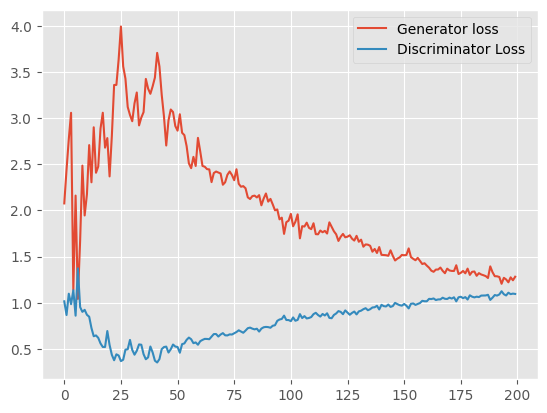

In [18]:
plt.figure()
losses_g = [f1.item() for f1 in losses_g]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()

처음 몇 에포크 동안 생성자의 오차는 증가하고 판별자의 오차는 감소하는 것을 볼 수 있습니다. 이러한 증상이 나타나는 이유는 학습 초기 단계에 생성자는 좋은 가짜 이미지를 생성하기 못하기에 판별자가 실제 이미지와 가짜 이미지를 쉽게 구분할 수 있기 때문입니다. 하지만 학습이 진행됨에 따라 생성자는 진짜와 같은 가짜 이미지를 만들어 판별자는 가짜 이미지 중 일부를 진짜로 분류합니다. 따라서 그림과 같이 생성자의 오차가 감소하면 판별자의 오차는 증가합니다.

앞의 이미지를 하나씩 쪼개서 확인하고 싶다면 다음 코드와 같이 실행하면 됩니다. 생성된 열 개의 이미지를 보여 줍니다.

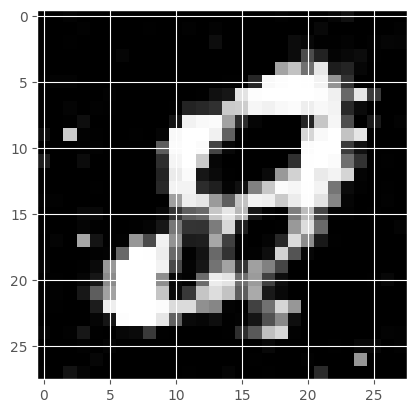

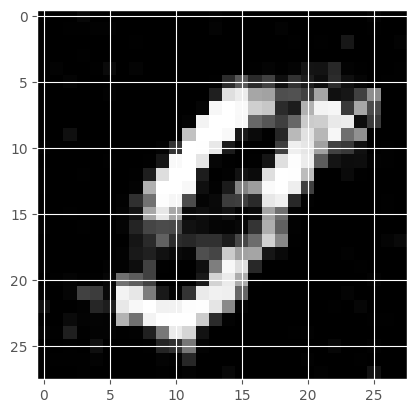

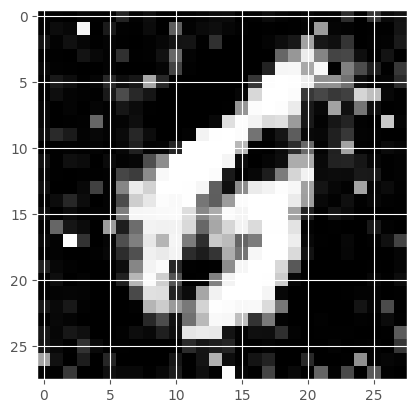

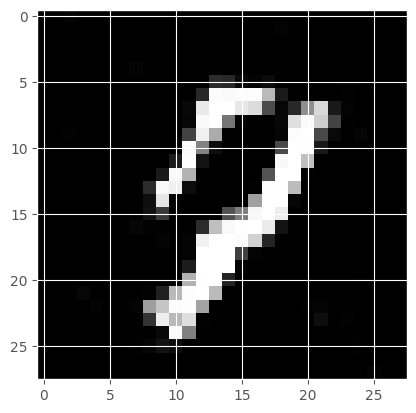

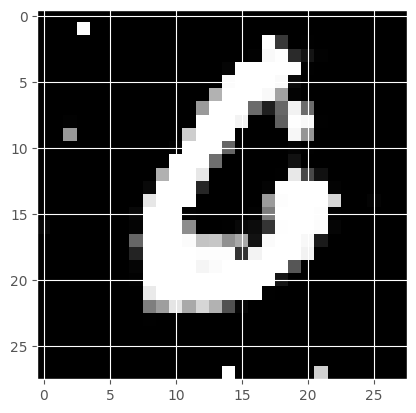

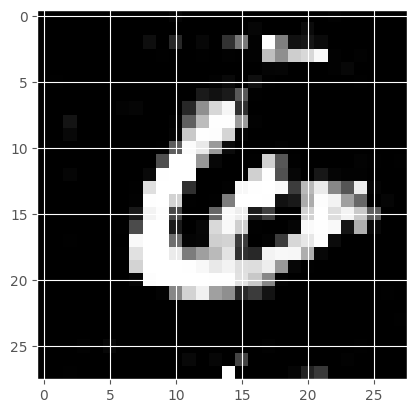

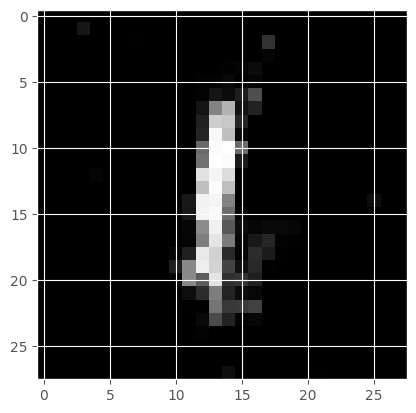

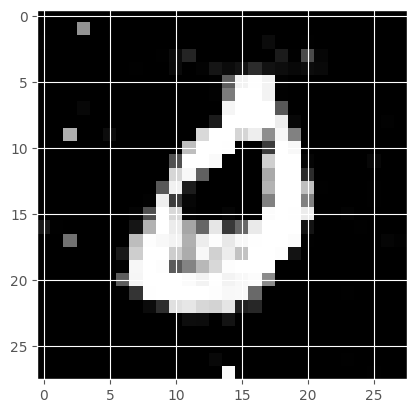

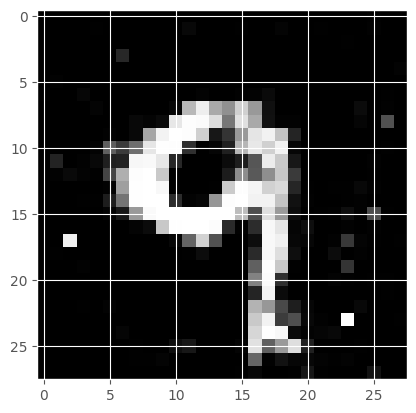

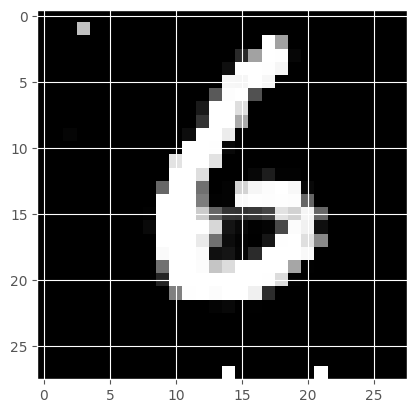

In [19]:
import numpy as np

fake_images = generator(torch.randn(b_size, nz).to(device))

for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28,28))
    plt.imshow(fake_images_img, cmap='gray')
    plt.savefig('./GANfake_images/fake_images_img' + str(i) + '.png')
    plt.show()